In [1]:
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from scipy import fft
import seaborn as sns
from math import pi
import pandas as pd
import numpy as np
import time

import wave 
# Opciones de matplotlib
rc=plt.rcParams
rc['figure.figsize']=[15,5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

Definimos las cantidades correspondientes a las características del problema

In [2]:
n_ventana=1024
freq_sampleo=48_000
N_mics=3


def arreglo_frecuencias(freq_sampleo,n_ventana):
    '''Función para obtener el arreglo de frecuencias que se obtendrían en la transformada de Fourier rápida'''
    f_NS=freq_sampleo//2
    freq_array=np.zeros(n_ventana)
    f1=freq_sampleo/n_ventana
    for i in range(1,len(freq_array)//2):
        freq_array[i]=f1*i 
        freq_array[len(freq_array)-i]=-freq_array[i]
    freq_array[n_ventana//2]=f_NS
    return freq_array

# Leyendo archivo de AIRA

Usando `wave` leemos el archivo de AIRA para comenzar las pruebas de music

In [3]:
def caracteristicas_onda(path):
    wave_object=wave.open(path,'rb')
    fr_AIRA=wave_object.getframerate() # 48000 Hz
    ns_AIRA=wave_object.getnframes() # 1539072 frames en total 
    T_AIRA=ns_AIRA/fr_AIRA # 32s 
    nchannels_AIRA=wave_object.getnchannels() # 1
    print(f'Caracteristicas de {path}')
    print('-'*70)
    print(f'{"Número total de frames:":25s} {ns_AIRA}')
    print(f'{f"Frame rate:":25s} {fr_AIRA} Hz')
    print(f'{"Duración total:":25s} {T_AIRA:4.2f} s')
    print(f'{"Número de canales de:":25s} {nchannels_AIRA}')

    return wave_object,fr_AIRA,ns_AIRA,T_AIRA,nchannels_AIRA

# Catacyerísticas de la onda
mic_path=['../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav','../Programas PDA/6. AIRA/clean-2source/wav_mic2.wav','../Programas PDA/6. AIRA/clean-2source/wav_mic3.wav']
mic1,fr_AIRA,ns_AIRA,T_AIRA,nchannels_AIRA=caracteristicas_onda(mic_path[0])
mic2=caracteristicas_onda(mic_path[1])[0]
mic3=caracteristicas_onda(mic_path[2])[0]


Caracteristicas de ../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav
----------------------------------------------------------------------
Número total de frames:   1539072
Frame rate:               48000 Hz
Duración total:           32.06 s
Número de canales de:     1
Caracteristicas de ../Programas PDA/6. AIRA/clean-2source/wav_mic2.wav
----------------------------------------------------------------------
Número total de frames:   1539072
Frame rate:               48000 Hz
Duración total:           32.06 s
Número de canales de:     1
Caracteristicas de ../Programas PDA/6. AIRA/clean-2source/wav_mic3.wav
----------------------------------------------------------------------
Número total de frames:   1539072
Frame rate:               48000 Hz
Duración total:           32.06 s
Número de canales de:     1


Definimos función para leer archivos y leer su contenido en numpy

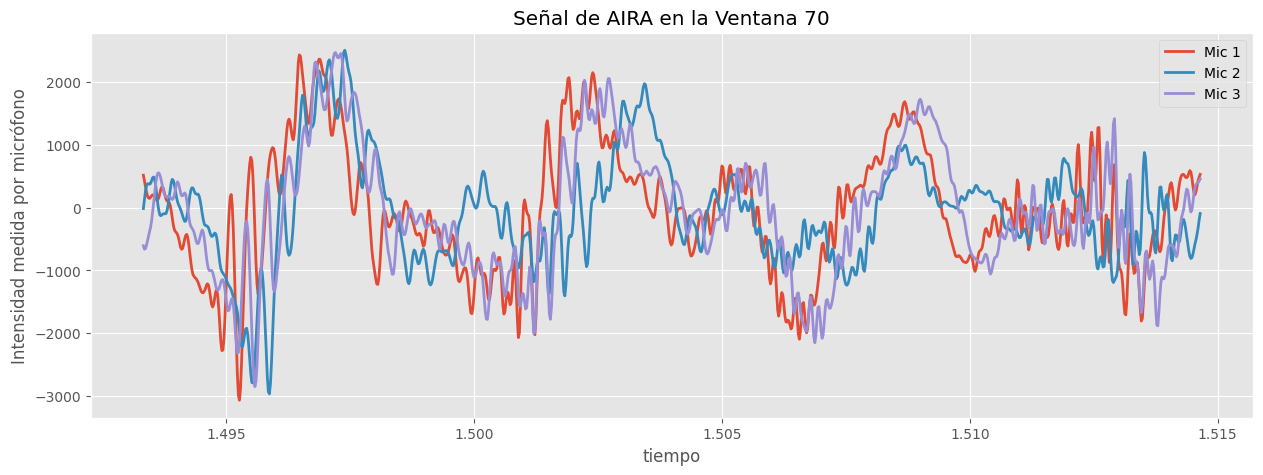

In [4]:
def leer_señal_array(path):
    wav_object=wave.open(f'{path}','rb')
    ns=wav_object.getnframes() # 1539072


    signal_wave=wav_object.readframes(ns)
    signal_array=np.frombuffer(signal_wave,dtype=np.int16)
    
    return signal_array


ventana_estudio=70 # Abajo de esta ventana empieza a agarrar ruido real

lista_señales_AIRA=[leer_señal_array(mic_path[0])[(1024*ventana_estudio):1024*(ventana_estudio+1)],leer_señal_array(mic_path[1])[(1024*ventana_estudio):1024*(ventana_estudio+1)],leer_señal_array(mic_path[2])[(1024*ventana_estudio):1024*(ventana_estudio+1)]]

n_ventanas_AIRA=lista_señales_AIRA[0].shape[0]//n_ventana 

time_AIRA=np.linspace(0,T_AIRA,num=ns_AIRA)[(1024*ventana_estudio):1024*(ventana_estudio+1)]


plt.title(f'Señal de AIRA en la Ventana {ventana_estudio}')
for i,li in enumerate(lista_señales_AIRA):
    plt.plot(time_AIRA,li,label=f'Mic {i+1}',linewidth=2)
plt.xlabel('tiempo'); plt.ylabel('Intensidad medida por micrófono')
plt.legend();plt.show();

## Cambiando A para ajustarse al arreglo triangular

Sabemos que la configuración de micrófonos de AIRA no es lineal, entonces tenemos que cambiar nuestros cálculos de los direction vectors. El arreglo está dado por 

![arr_AIRA](./imgs/arr_AIRA.png)



Para los dos primeros micrófonos es lo mismo, para el tercero es donde hay que cambiarlo. 

Como el triángulo entre los micrófonos es equilátero y la dirección contrarreloj es negativa, tenemos $$\theta_{m3}=-\frac{\pi}{2}-\frac{\pi}{3}=-\frac{5}{6}\pi$$

Así, el direction vector queda como 

$$ 
\begin{align}
{\vec{a}(\theta)}_{AIRA}^{f}=\begin{pmatrix}
1\\
e^{-if\frac{2\pi d}{c}\sin(\theta) }\\
e^{-if\frac{2\pi d}{c}\cos(-\frac{5}{6}\pi-\theta)}
\end{pmatrix}

\end{align}
$$


In [5]:
dm_AIRA=0.18 # Separación de micrófonos en metros (todas las separaciones son iguales porque es arreglo triangular equilátero)
c=343 #m/s

DOAS_AIRA=[-30,90]
N_mic_AIRA=3

def a_theta_f_AIRA(θ,freq,dm_AIRA=dm_AIRA,c=c):
    '''
    θ: Dirección de arribo con respecto a la referencia
    f: frecuencia de la señal
    dim: distancia entre micrófonos, para el arreglo de AIRA es el mismo porque es triángulo equilatero
    Genera los steering vector en la dirección θ para el arreglo triangular de AIRA
    '''
    θ_rad=θ*pi/180
    k=-2*pi*dm_AIRA/c*np.sin(θ_rad)
    a=[
        1+0j, # Micrófono 1
        np.exp(k*freq*1j), # Micrófono 2
        np.exp(-2*pi*freq*dm_AIRA/c*np.cos(-5*pi/6-θ_rad)*1j) # Micrófono 3
       ]
    return np.array(a)

def A_f_AIRA(θs,freq,dm_AIRA=dm_AIRA,c=c):
    '''
    Función que genera la matriz de steering vectors para una frecuencia específica con varias fuentes ubicadas en θs
    '''
    A=np.zeros(shape=(N_mic_AIRA,len(θs)))+0j
    for i in range(len(θs)):
        A[:,i]=a_theta_f_AIRA(θs[i],freq,dm_AIRA=dm_AIRA,c=c)
    
    return A


def A_AIRA(θs,freqs,dm_AIRA=dm_AIRA,c=c):
    '''
    Para arreglo lineal. 
    Calcula el tensor A para las frecuencias requeridas apliando matrices de steering vectors
    '''
    A=np.zeros(shape=(len(freqs),N_mic_AIRA,len(θs)))+0j
    for i in range(len(freqs)):
        A[i,:,:]=A_f_AIRA(θs,freqs[i],dm_AIRA=dm_AIRA,c=c)
    
    return A



# Aproximando señales con transformación de $A$

Vemos las señales originales las transformamos con la A y esperamos ver algo parecido a la de los micrófonos 

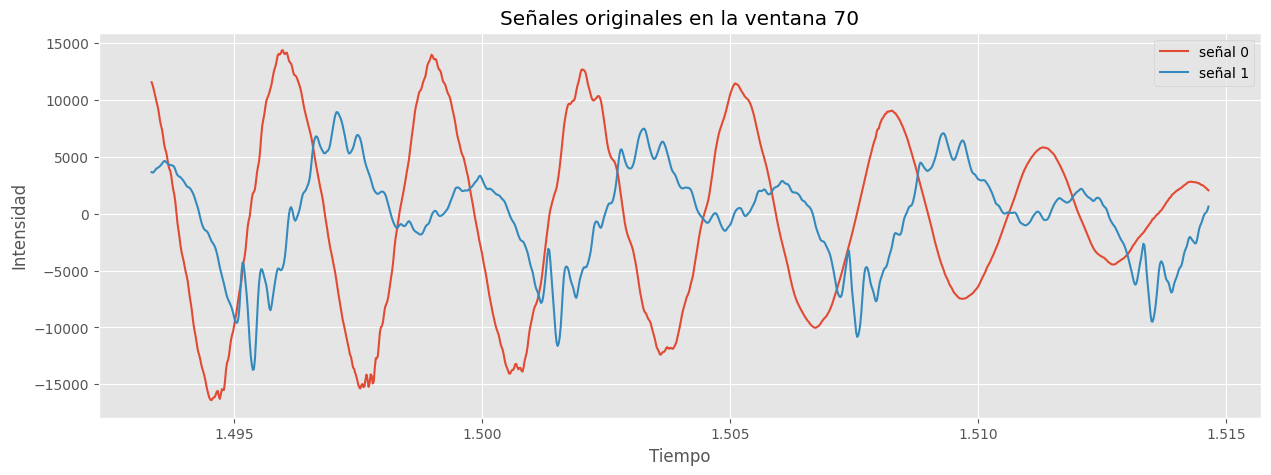

In [6]:
s1_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel1.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
s2_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel2.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]

freq_array_AIRA=arreglo_frecuencias(freq_sampleo=fr_AIRA,n_ventana=1024)
s_vec_AIRA=np.c_[s1_AIRA,s2_AIRA]

plt.title(f'Señales originales en la ventana {ventana_estudio}')
for i,si in enumerate(s_vec_AIRA.T):
    plt.plot(time_AIRA,si,label=f'señal {i}')
plt.xlabel('Tiempo');plt.ylabel('Intensidad');plt.legend();plt.show()

In [7]:
A_AIRA_mat=A_AIRA(DOAS_AIRA,freq_array_AIRA)
s_hat_vec_AIRA=fft.fft(s_vec_AIRA,axis=0)
x_mics_AIRA_señal=np.zeros((N_mic_AIRA,len(freq_array_AIRA)))+0j
for i in range(A_AIRA_mat.shape[0]):
    x_mics_AIRA_señal[:,i]=A_AIRA_mat[i,:,:]@s_hat_vec_AIRA[i,:]
x_mics_AIRA_señal=fft.ifft(x_mics_AIRA_señal,axis=1).real

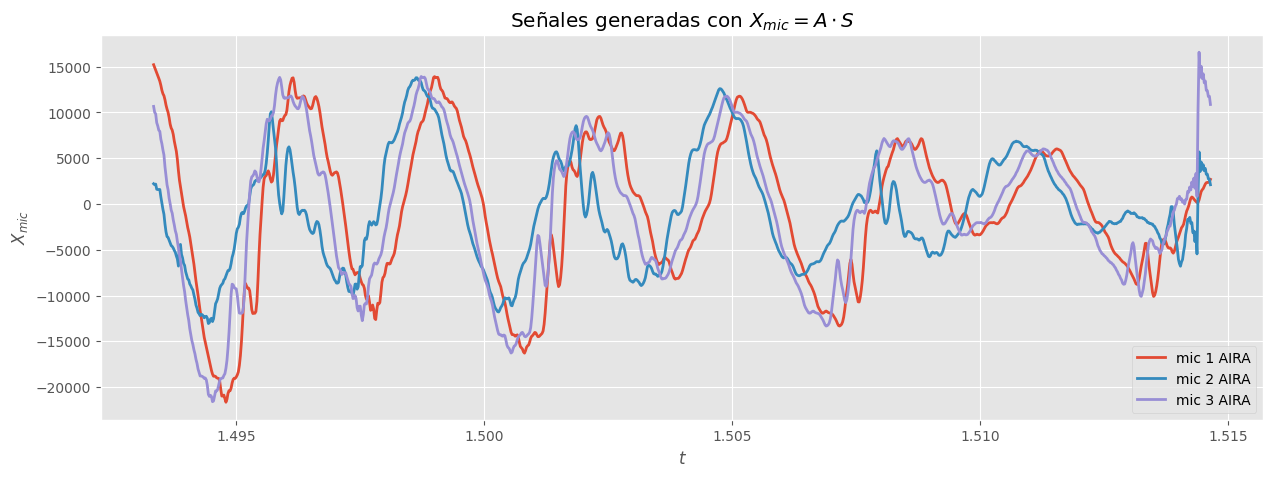

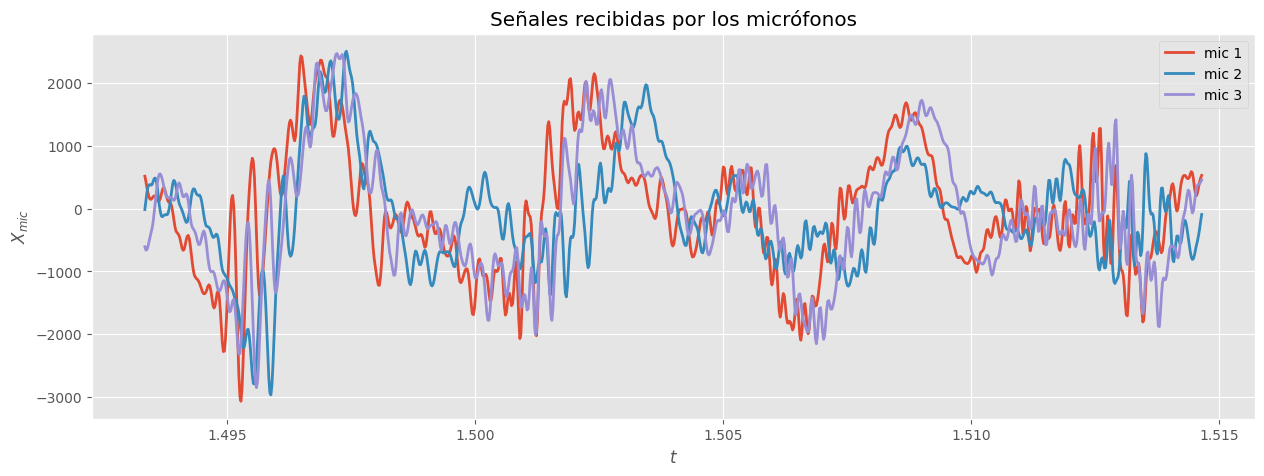

In [8]:

plt.plot(time_AIRA,x_mics_AIRA_señal[0],label='mic 1 AIRA',linewidth=2)
plt.plot(time_AIRA,x_mics_AIRA_señal[1],label='mic 2 AIRA',linewidth=2)
plt.plot(time_AIRA,x_mics_AIRA_señal[2],label='mic 3 AIRA',linewidth=2)
plt.title('Señales generadas con $X_{mic}=A\\cdot S$');plt.legend(); plt.xlabel('$t$');plt.ylabel('$X_{mic}$');plt.show()

plt.plot(time_AIRA,lista_señales_AIRA[0],label='mic 1',linewidth=2)
plt.plot(time_AIRA,lista_señales_AIRA[1],label='mic 2',linewidth=2)
plt.plot(time_AIRA,lista_señales_AIRA[2],label='mic 3',linewidth=2)
plt.title('Señales recibidas por los micrófonos');plt.legend(); plt.xlabel('$t$');plt.ylabel('$X_{mic}$');plt.show()

la diferencia con las señales de los micrófonos se debe a el ruido, reverb y la distancia? Cómo se podría emular esto para crear señales sintéticas y poder hacer experimentos con diferentes señales?

También se podría cambiar la frecuencia de una señal y ver si esto ayuda a mejorar el proceso de  DOA. Poner una de ellas muy aguda y la otra muy grave. 

# MUSIC con señal real

Redefinimos la función de MUSIC para que agarre el arreglo triangular de AIRA

In [9]:
def MUSIC_AIRA(freq_array,this_idx,x_mics,angles,n_ruidoso):
    '''
    Función para encontrar el espectro de music. Depende del arreglo de micrófonos a través de A_completa
    x_mics: el arreglo de señales que ve cada micrófono
    '''
    this_ws=freq_array[this_idx] # Frecuencias donde se van a buscar los picos del espectro de MUSIC
    X=fft.fft(x_mics,axis=1) # se hace la transformada a lo largo del eje 1 para obtener una transformada por cada mic
    music_spectrum=np.zeros(shape=(len(this_ws),len(angles)))
    for i,idx in enumerate(this_idx):
        this_X=X[:,idx] # Esta es la que tiene que ser calculada usando ventanas anteriores. Cuando dividas en varias ventanas de Hann, se debería de ver una diferencia en la estimación
        R=this_X.reshape(-1,1)*this_X.conj().T
        D,Q=np.linalg.eig(R)
        I=np.argsort(D.real)[::-1]
        D=D[I]
        Q=Q[:,I]


        # Qs=Q[:,1:n_ruidoso]
        Qn=Q[:,n_ruidoso:]

        wi=this_ws[i]
        A_angles=A_AIRA(θs=angles,freqs=[wi])

        for k in range(len(angles)):
            music_spectrum[i,k]=np.abs(1/(A_angles[0,:,k].conj().T@(Qn*Qn.conj().T@A_angles[0,:,k])))
    return music_spectrum


Como esto tiene que correr en tiempo real, se debe realizar en menos de $$t_{\text{ventana}}=\frac{\text{frames por ventana}}{\text{frame rate}}=\frac{1024}{48000 \text{ Hz}}\approx 0.021 \text{s}$$

Frecuencia fundamental típica de un hombre va de 80 a 150Hz mientras que la de una mujer va de 166 a 255Hz ([Fuente Wikipedia](https://en.wikipedia.org/wiki/Voice_frequency)).

Entonces vamos a buscar en espacio de frecuencias para music que incluya estas frecuencias aunque también deberíamos incluir más porque 

In [13]:
periodo_AIRA=n_ventana/fr_AIRA
this_idx_AIRA=np.arange(8,40,5)
this_ws_AIRA=freq_array_AIRA[this_idx_AIRA]

x_mics_AIRA=np.array(lista_señales_AIRA)
n_ruidoso_AIRA=2
# frecuencias fundamentales de la voz humana de hombre van de 80 a 180 Hz

angles_AIRA=np.linspace(-90,90,50) # Los ángulos para buscar ortogonalidad

In [14]:
%%timeit

music_spectrum_AIRA=MUSIC_AIRA(freq_array=freq_array_AIRA,this_idx=this_idx_AIRA,x_mics= x_mics_AIRA,angles=angles_AIRA,n_ruidoso=n_ruidoso_AIRA)

5.8 ms ± 945 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Como tarda $\approx 5.54 \text{ ms}<20 -text{ ms}$ en acabar, se puede hacer el cálculo del espectro de music y aún así seguir debajo del límite para cálculo en línea. Todavía tenemos que calcular los máximos y ver que el tiempo se queda dentro de lo establecido

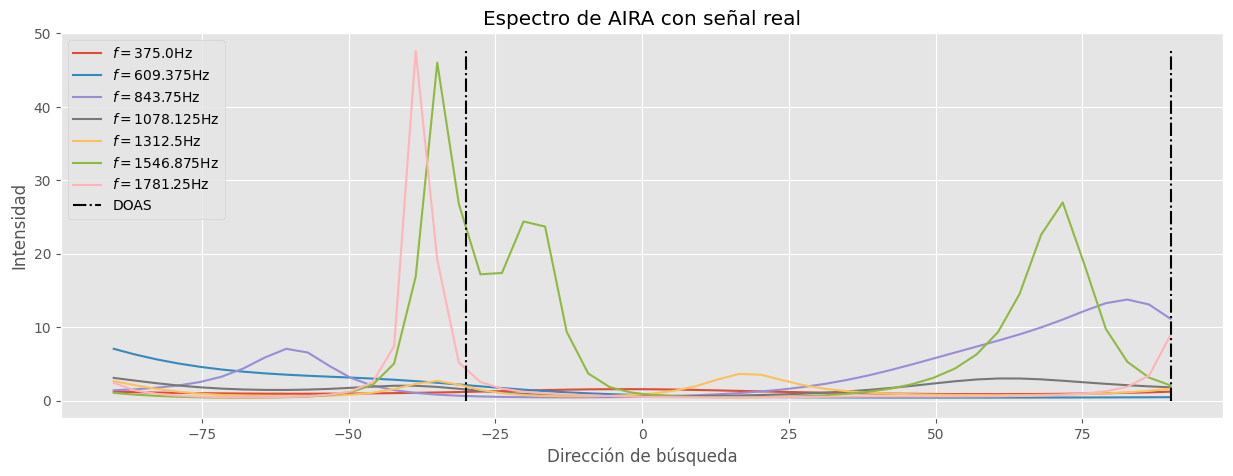

In [15]:
music_spectrum_AIRA=MUSIC_AIRA(freq_array=freq_array_AIRA,this_idx=this_idx_AIRA,x_mics= x_mics_AIRA,angles=angles_AIRA,n_ruidoso=n_ruidoso_AIRA)

for i in range(music_spectrum_AIRA.shape[0]):
    plt.plot(angles_AIRA,music_spectrum_AIRA[i,:],label=f'$f={this_ws_AIRA[i]} $Hz')

plt.vlines(x=DOAS_AIRA,ymin=0,ymax=music_spectrum_AIRA.max(),colors='k',linestyles='dashdot',label='DOAS');plt.legend();plt.title('Espectro de AIRA con señal real'); plt.xlabel('Dirección de búsqueda');plt.ylabel('Intensidad'); plt.show()

Hay que ver también el problema de la distancia entre micrófonos

descomposición generalizada de valor singular para hacerlo más rápido

Dejar las partes del cálculo de la matriz de covarianza y lo de eigenvectores como módulos para poder ponerlos mejor después.

soundfile


# Usando la estimación de la matriz X

La matriz $X$ se está calculando paso a paso pero se puede estimar con los pasos anteriores a tavés de ![est](cov.png)

# Vemos cuánto dura una iteración 

In [84]:
idx=this_idx_AIRA[0]
angles_AIRA=np.linspace(-90,90,50) # Los ángulos para buscar ortogonalidad
n_ruidoso=2
X=x_mics_AIRA
t1=time.time()
X=fft.fft(X,axis=1)
this_X=X[:,idx] # Esta es la que tiene que ser calculada usando ventanas anteriores. Cuando dividas en varias ventanas de Hann, se debería de ver una diferencia en la estimación
R=this_X.reshape(-1,1)*this_X.conj().T

D,Q=np.linalg.eig(R)
I=np.argsort(D.real)[::-1]
D=D[I]
Q=Q[:,I]

# Qs=Q[:,1:n_ruidoso]
Qn=Q[:,n_ruidoso:]
wi=this_ws_AIRA[0]
A_angles=A_AIRA(θs=angles_AIRA,freqs=[wi])

print(time.time()-t1)

0.0025682449340820312


la lección aquí es reducir el número de ángulos de búsqueda y tal vez inferir el resto.